In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression ,Ridge , Lasso
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score ,KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler ,LabelEncoder
from catboost import CatBoostRegressor
import math
from sklearn.metrics import mean_squared_log_error ,r2_score

sns.set_theme(style="ticks", color_codes=True)
%matplotlib inline

In [2]:
#Trainig file 
df_train = pd.read_csv('TRAIN (1).csv')

# Testing file
df_test = pd.read_csv('TEST_FINAL.csv')

In [3]:
df_train.head(3)

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,#Order,Sales
0,T1000001,1,S1,L3,R1,2018-01-01,1,Yes,9,7011.84
1,T1000002,253,S4,L2,R1,2018-01-01,1,Yes,60,51789.12
2,T1000003,252,S3,L2,R1,2018-01-01,1,Yes,42,36868.20


In [4]:
df_test.head(4)

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount
0,T1188341,171,S4,L2,R3,2019-06-01,0,No
1,T1188342,172,S1,L1,R1,2019-06-01,0,No
2,T1188343,173,S4,L2,R1,2019-06-01,0,No
3,T1188344,174,S1,L1,R4,2019-06-01,0,No


In [5]:
df_train.describe()

,Store_id,Holiday,#Order,Sales
count,188340.000000,188340.000000,188340.000000,188340.000000
mean,183.000000,0.131783,68.205692,42784.327982
std,105.366308,0.338256,30.467415,18456.708302
min,1.000000,0.000000,0.000000,0.000000
25%,92.000000,0.000000,48.000000,30426.000000
50%,183.000000,0.000000,63.000000,39678.000000
75%,274.000000,0.000000,82.000000,51909.000000
max,365.000000,1.000000,371.000000,247215.000000


In [6]:
df_train.apply(lambda x : len(x.unique()))

ID               188340
Store_id            365
Store_Type            4
Location_Type         5
Region_Code           4
Date                516
Holiday               2
Discount              2
#Order              299
Sales             47422
dtype: int64

In [7]:
#Checking information about the dataset
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188340 entries, 0 to 188339
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   ID             188340 non-null  object 
 1   Store_id       188340 non-null  int64  
 2   Store_Type     188340 non-null  object 
 3   Location_Type  188340 non-null  object 
 4   Region_Code    188340 non-null  object 
 5   Date           188340 non-null  object 
 6   Holiday        188340 non-null  int64  
 7   Discount       188340 non-null  object 
 8   #Order         188340 non-null  int64  
 9   Sales          188340 non-null  float64
dtypes: float64(1), int64(3), object(6)
memory usage: 14.4+ MB


In [8]:
#Checking NULL values
df_train.isnull().sum()

ID               0
Store_id         0
Store_Type       0
Location_Type    0
Region_Code      0
Date             0
Holiday          0
Discount         0
#Order           0
Sales            0
dtype: int64

In [9]:
# Checking categorical features and confirming whether it has duplicate categories
a , b , c ,d = set(df_train['Store_Type']),set(df_train['Location_Type']) ,set(df_train['Region_Code']),set(df_train['Discount'])
print(a,b,c,d)

{'S3', 'S1', 'S2', 'S4'} {'L1', 'L5', 'L4', 'L3', 'L2'} {'R3', 'R4', 'R1', 'R2'} {'No', 'Yes'}


## Exploratory Data Analysis

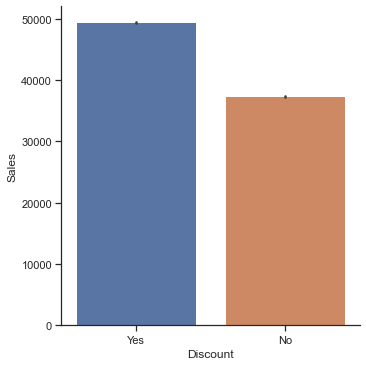

In [10]:
sns.catplot(x=df_train['Discount'] ,y= df_train['Sales'], data = df_train ,kind = 'bar')

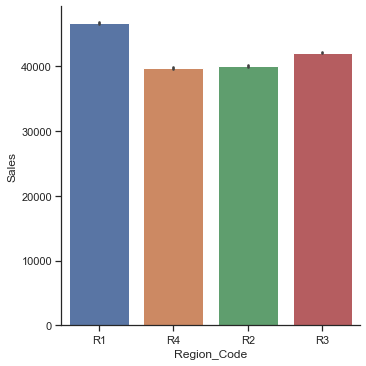

In [11]:
#Checking sales outcome w.r.t region
sns.catplot(x=df_train['Region_Code'],y=df_train['Sales'],data = df_train , kind = 'bar')

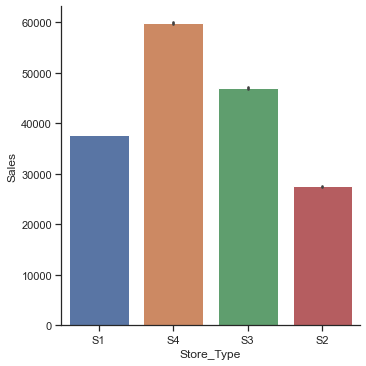

In [12]:
# sales outcome by location type w.r.t region
sns.catplot(x=df_train['Store_Type'],y=df_train['Sales'],kind = 'bar',data = df_train)

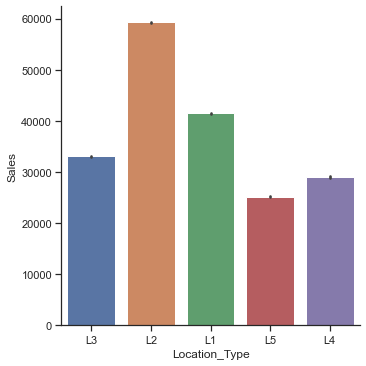

In [13]:
sns.catplot(x=df_train['Location_Type'],y=df_train['Sales'],kind = 'bar',data = df_train)

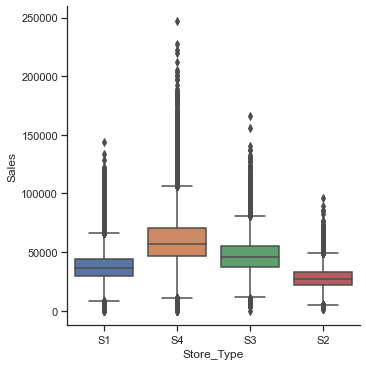

In [14]:
#Checking outliers w.r.t store type 
sns.catplot(x=df_train['Store_Type'],y=df_train['Sales'],kind ='box',data = df_train)

## Feature Engineering

In [15]:
#copying training...
train = df_train.copy()

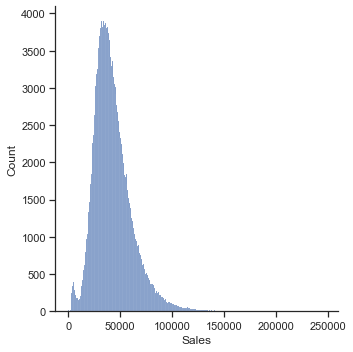

In [16]:
sns.displot(train['Sales'])

In [17]:
# IQR
Q1 = np.percentile(train['Sales'], 25,
                   interpolation = 'midpoint')
 
Q3 = np.percentile(train['Sales'], 75,
                   interpolation = 'midpoint')
IQR = Q3 - Q1
 
print("Old Shape: ", train.shape)
 
# Upper bound
upper = np.where(train['Sales'] >= (Q3+1.5*IQR))
# Lower bound
lower = np.where(train['Sales'] <= (Q1-1.5*IQR))
 
''' Removing the Outliers '''
train.drop(upper[0] ,inplace = True)
train.drop(lower[0],inplace = True )
 
print("New Shape: ", train.shape)

Old Shape:  (188340, 10)
New Shape:  (182497, 10)


In [18]:
#checking rows which have no sales 

zero_sales = train[train['Sales']<=0].index
len(zero_sales)

19

In [19]:
train.drop(zero_sales ,inplace = True)

#  Encoding and Transformation

In [20]:
# Applying one hot encoding with store_type,'Discount' ,location_type

train = pd.get_dummies(train ,columns=['Store_Type','Location_Type','Discount'])

#Encoding Region codes
reg_encode= LabelEncoder()
train['Region_Code'] = reg_encode.fit_transform(train['Region_Code'])

#Converting date column to date time object
train['Date'] = pd.to_datetime(train['Date'])

# Extracting month from date 
train['Month'] = train['Date'].dt.month

# #Extracting days from date 
train['sale_weekdays'] = train['Date'].dt.dayofweek

#sale on weekend and week day apart
train['sale_week'] = train['sale_weekdays'].apply(lambda x : 1 if x >=5 else 0 )


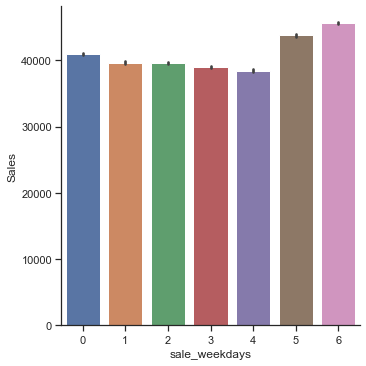

In [21]:
sns.catplot(x=train['sale_weekdays'],y=train['Sales'],kind = 'bar',data = train)

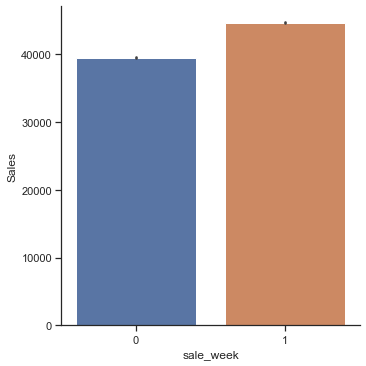

In [22]:
#Sale on weekdays vs weekend
sns.catplot(x=train['sale_week'],y=train['Sales'],kind = 'bar',data = train)

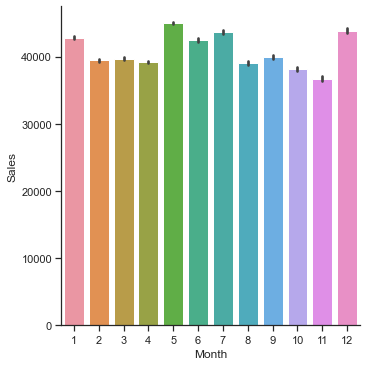

In [23]:
# Months vs sale visualisation
sns.catplot(x=train['Month'],y=train['Sales'],kind = 'bar',data = train)

In [24]:
#sart date
train['Date'].min()

Timestamp('2018-01-01 00:00:00')

In [25]:
#end date
train['Date'].max()

Timestamp('2019-05-31 00:00:00')

In [26]:
train.head(3)

,ID,Store_id,Region_Code,Date,Holiday,#Order,Sales,Store_Type_S1,Store_Type_S2,Store_Type_S3,...,Location_Type_L1,Location_Type_L2,Location_Type_L3,Location_Type_L4,Location_Type_L5,Discount_No,Discount_Yes,Month,sale_weekdays,sale_week
0,T1000001,1,0,2018-01-01,1,9,7011.84,1,0,0,...,0,0,1,0,0,0,1,1,0,0
1,T1000002,253,0,2018-01-01,1,60,51789.12,0,0,0,...,0,1,0,0,0,0,1,1,0,0
2,T1000003,252,0,2018-01-01,1,42,36868.20,0,0,1,...,0,1,0,0,0,0,1,1,0,0


In [27]:
# Dropping unnecessary columns
train.drop(['ID','Date'	,'sale_weekdays'] ,axis = 1 ,inplace = True)

In [28]:
#moving sales column to the last position

move_train = train.pop('Sales')
train.insert(len(train.columns),'Sales' ,move_train)

In [29]:
train.head(3)

,Store_id,Region_Code,Holiday,#Order,Store_Type_S1,Store_Type_S2,Store_Type_S3,Store_Type_S4,Location_Type_L1,Location_Type_L2,Location_Type_L3,Location_Type_L4,Location_Type_L5,Discount_No,Discount_Yes,Month,sale_week,Sales
0,1,0,1,9,1,0,0,0,0,0,1,0,0,0,1,1,0,7011.84
1,253,0,1,60,0,0,0,1,0,1,0,0,0,0,1,1,0,51789.12
2,252,0,1,42,0,0,1,0,0,1,0,0,0,0,1,1,0,36868.20


# Test Data Preprocessing

In [30]:
test = df_test.copy()

In [31]:
test.head(3)

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount
0,T1188341,171,S4,L2,R3,2019-06-01,0,No
1,T1188342,172,S1,L1,R1,2019-06-01,0,No
2,T1188343,173,S4,L2,R1,2019-06-01,0,No


In [32]:
# Checking null values
test.isnull().sum()

ID               0
Store_id         0
Store_Type       0
Location_Type    0
Region_Code      0
Date             0
Holiday          0
Discount         0
dtype: int64

In [33]:
# Info
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22265 entries, 0 to 22264
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ID             22265 non-null  object
 1   Store_id       22265 non-null  int64 
 2   Store_Type     22265 non-null  object
 3   Location_Type  22265 non-null  object
 4   Region_Code    22265 non-null  object
 5   Date           22265 non-null  object
 6   Holiday        22265 non-null  int64 
 7   Discount       22265 non-null  object
dtypes: int64(2), object(6)
memory usage: 1.4+ MB


In [34]:
# Applying one hot encoding with store_type,'Discount' ,location_type

test = pd.get_dummies(test ,columns=['Store_Type','Location_Type','Discount'])

#Encoding Region codes
reg_encode= LabelEncoder()
test['Region_Code'] = reg_encode.fit_transform(test['Region_Code'])

#Converting date column to date time object
test['Date'] = pd.to_datetime(test['Date'])

# Extracting month from date 
test['Month'] = test['Date'].dt.month

# #Extracting days from date 
test['sale_weekdays'] = test['Date'].dt.dayofweek

#sale on weekend and week day apart
test['sale_week'] = test['sale_weekdays'].apply(lambda x : 1 if x >=5 else 0 )


In [35]:
#start date
test['Date'].min()

Timestamp('2019-06-01 00:00:00')

In [36]:
#end date
test['Date'].max()

Timestamp('2019-07-31 00:00:00')

In [37]:
test.drop(['ID','Date'	,'sale_weekdays'] ,axis = 1 ,inplace = True)

In [38]:
test.head(3)

,Store_id,Region_Code,Holiday,Store_Type_S1,Store_Type_S2,Store_Type_S3,Store_Type_S4,Location_Type_L1,Location_Type_L2,Location_Type_L3,Location_Type_L4,Location_Type_L5,Discount_No,Discount_Yes,Month,sale_week
0,171,2,0,0,0,0,1,0,1,0,0,0,1,0,6,1
1,172,0,0,1,0,0,0,1,0,0,0,0,1,0,6,1
2,173,0,0,0,0,0,1,0,1,0,0,0,1,0,6,1


# Finding order columns in test data by training the models 

In [39]:
train.columns

Index(['Store_id', 'Region_Code', 'Holiday', '#Order', 'Store_Type_S1',
       'Store_Type_S2', 'Store_Type_S3', 'Store_Type_S4', 'Location_Type_L1',
       'Location_Type_L2', 'Location_Type_L3', 'Location_Type_L4',
       'Location_Type_L5', 'Discount_No', 'Discount_Yes', 'Month', 'sale_week',
       'Sales'],
      dtype='object')

In [40]:
#Selecting only those column which are present in training data
columns = ['Store_id', 'Region_Code', 'Holiday', 
       'Store_Type_S1', 'Store_Type_S2', 'Store_Type_S3', 'Store_Type_S4',
       'Location_Type_L1', 'Location_Type_L2', 'Location_Type_L3',
       'Location_Type_L4', 'Location_Type_L5', 'Discount_No', 'Discount_Yes',
       'Month', 'sale_week']

        
#Features columns for predicting order
ord_train = train[columns]

#Target columns for order
ord_target = train['#Order']

In [41]:
#Initialising....
reg = LinearRegression()

#Fitting the model
reg.fit(ord_train,ord_target)

LinearRegression()

In [42]:
#Predicting order 
y_pred = reg.predict(test)

#Converting it into integer as order cannot be float value 
y_pred = [int(i) for i in y_pred]

#Merging into the test data ...
test.insert(3,'#Order' ,y_pred)

In [43]:
test.head(3)

,Store_id,Region_Code,Holiday,#Order,Store_Type_S1,Store_Type_S2,Store_Type_S3,Store_Type_S4,Location_Type_L1,Location_Type_L2,Location_Type_L3,Location_Type_L4,Location_Type_L5,Discount_No,Discount_Yes,Month,sale_week
0,171,2,0,98,0,0,0,1,0,1,0,0,0,1,0,6,1
1,172,0,0,63,1,0,0,0,1,0,0,0,0,1,0,6,1
2,173,0,0,102,0,0,0,1,0,1,0,0,0,1,0,6,1


# Training models and evaluating it's performance

In [44]:
# Feature columns 
X = train.iloc[:,:-1]

#Target
y = train.loc[:,'Sales']

In [47]:
# This 'test' dataframe is given your problem satement to get prediction 
    # train the model
def salesPrediction(model,model_name , X, y ,test): 
    model.fit(X, y)
    
    # predict the training set
    pred = model.predict(X)
    
    # perform cross-validation
    folds = KFold(n_splits = 5, shuffle = True, random_state = 100)
    cv_score = cross_val_score(model, X, y , scoring='r2', cv=folds)
    cv_score = np.mean(cv_score)
    
    print("Model Performance Synapsis")
    print("CV Score:", cv_score)
    
    
    #Submission prediction ..
    predict_submit = model.predict(test) 
    predict_submit= [int(i) for i in predict_submit]
    submission = pd.read_csv('SAMPLE.csv')
    submission["Sales"] = predict_submit
    submission.to_csv(f'sub_{model_name}.csv', index=False)

In [48]:
# Linear Regression
lm = LinearRegression(normalize=True)
salesPrediction(lm,'Linear' ,X , y ,test)


Model Performance Synapsis
CV Score: 0.9112103547000234


In [49]:
#Lasso regression
laso_reg = Lasso(normalize=True)
salesPrediction(laso_reg,'Laso' ,X , y ,test)

Model Performance Synapsis
CV Score: 0.9003587308220288


In [50]:
# Ridge Regression
rid_reg = Ridge(normalize=True)
salesPrediction(rid_reg,'Ridge' ,X , y ,test)

Model Performance Synapsis
CV Score: 0.7484490441630463


In [ ]:
# Random forest Regressor
rfg = RandomForestRegressor()
salesPrediction(rfg,'randForest' ,X , y ,test)

In [51]:
# Cat Boost Regressor
cat_model = CatBoostRegressor(loss_function="RMSE")
salesPrediction(cat_model,'catBoost' ,X , y ,test)

Learning rate set to 0.098604
0:	learn: 14058.6172806	total: 79.9ms	remaining: 1m 19s
1:	learn: 12945.5155634	total: 96.1ms	remaining: 47.9s
2:	learn: 11957.0665650	total: 111ms	remaining: 36.8s
3:	learn: 11070.5556074	total: 125ms	remaining: 31.1s
4:	learn: 10293.8134753	total: 139ms	remaining: 27.6s
5:	learn: 9593.1492984	total: 154ms	remaining: 25.5s
6:	learn: 8984.8168044	total: 175ms	remaining: 24.8s
7:	learn: 8435.2404980	total: 202ms	remaining: 25s
8:	learn: 7944.7200190	total: 224ms	remaining: 24.7s
9:	learn: 7515.2296334	total: 242ms	remaining: 23.9s
10:	learn: 7146.2921223	total: 259ms	remaining: 23.3s
11:	learn: 6807.8447079	total: 275ms	remaining: 22.7s
12:	learn: 6514.0465879	total: 290ms	remaining: 22s
13:	learn: 6244.1943545	total: 304ms	remaining: 21.4s
14:	learn: 6019.2661363	total: 318ms	remaining: 20.9s
15:	learn: 5800.8154565	total: 332ms	remaining: 20.4s
16:	learn: 5627.1380716	total: 346ms	remaining: 20s
17:	learn: 5479.2230975	total: 360ms	remaining: 19.7s
18:	le

159:	learn: 3195.5396036	total: 3.13s	remaining: 16.5s
160:	learn: 3190.0520364	total: 3.16s	remaining: 16.5s
161:	learn: 3187.1534913	total: 3.19s	remaining: 16.5s
162:	learn: 3183.8421827	total: 3.21s	remaining: 16.5s
163:	learn: 3180.4122889	total: 3.23s	remaining: 16.5s
164:	learn: 3177.4497262	total: 3.25s	remaining: 16.4s
165:	learn: 3174.2878602	total: 3.27s	remaining: 16.4s
166:	learn: 3172.6241977	total: 3.28s	remaining: 16.4s
167:	learn: 3171.5406010	total: 3.3s	remaining: 16.3s
168:	learn: 3169.4636445	total: 3.31s	remaining: 16.3s
169:	learn: 3165.8040432	total: 3.33s	remaining: 16.3s
170:	learn: 3163.8107278	total: 3.36s	remaining: 16.3s
171:	learn: 3162.0695289	total: 3.39s	remaining: 16.3s
172:	learn: 3159.6712346	total: 3.4s	remaining: 16.3s
173:	learn: 3157.2279815	total: 3.42s	remaining: 16.3s
174:	learn: 3155.4141226	total: 3.44s	remaining: 16.2s
175:	learn: 3152.7296755	total: 3.46s	remaining: 16.2s
176:	learn: 3149.5105943	total: 3.48s	remaining: 16.2s
177:	learn: 

321:	learn: 2894.7889637	total: 5.63s	remaining: 11.9s
322:	learn: 2893.5351737	total: 5.65s	remaining: 11.8s
323:	learn: 2891.8732605	total: 5.67s	remaining: 11.8s
324:	learn: 2890.9596012	total: 5.68s	remaining: 11.8s
325:	learn: 2890.3055276	total: 5.7s	remaining: 11.8s
326:	learn: 2889.3378049	total: 5.71s	remaining: 11.8s
327:	learn: 2888.9501051	total: 5.73s	remaining: 11.7s
328:	learn: 2888.3662119	total: 5.74s	remaining: 11.7s
329:	learn: 2887.8217679	total: 5.75s	remaining: 11.7s
330:	learn: 2885.9157657	total: 5.77s	remaining: 11.7s
331:	learn: 2884.8679130	total: 5.79s	remaining: 11.6s
332:	learn: 2884.3494980	total: 5.8s	remaining: 11.6s
333:	learn: 2883.5619290	total: 5.81s	remaining: 11.6s
334:	learn: 2882.3106121	total: 5.83s	remaining: 11.6s
335:	learn: 2881.4543131	total: 5.85s	remaining: 11.6s
336:	learn: 2881.0029136	total: 5.86s	remaining: 11.5s
337:	learn: 2878.1127949	total: 5.88s	remaining: 11.5s
338:	learn: 2876.7296497	total: 5.89s	remaining: 11.5s
339:	learn: 

471:	learn: 2758.5010288	total: 7.87s	remaining: 8.81s
472:	learn: 2757.9293355	total: 7.89s	remaining: 8.8s
473:	learn: 2757.0968445	total: 7.91s	remaining: 8.78s
474:	learn: 2756.8136946	total: 7.92s	remaining: 8.76s
475:	learn: 2755.5131848	total: 7.94s	remaining: 8.74s
476:	learn: 2754.4979197	total: 7.95s	remaining: 8.72s
477:	learn: 2753.6100319	total: 7.96s	remaining: 8.7s
478:	learn: 2753.2215096	total: 7.98s	remaining: 8.68s
479:	learn: 2752.4939332	total: 7.99s	remaining: 8.66s
480:	learn: 2751.9145680	total: 8s	remaining: 8.64s
481:	learn: 2750.6317785	total: 8.02s	remaining: 8.62s
482:	learn: 2749.8011228	total: 8.03s	remaining: 8.6s
483:	learn: 2748.5089650	total: 8.04s	remaining: 8.58s
484:	learn: 2748.2645798	total: 8.06s	remaining: 8.56s
485:	learn: 2748.0782872	total: 8.07s	remaining: 8.54s
486:	learn: 2747.7825872	total: 8.09s	remaining: 8.53s
487:	learn: 2746.7620861	total: 8.11s	remaining: 8.51s
488:	learn: 2746.5150919	total: 8.12s	remaining: 8.49s
489:	learn: 2745

626:	learn: 2670.5959370	total: 10.2s	remaining: 6.05s
627:	learn: 2669.8258674	total: 10.2s	remaining: 6.04s
628:	learn: 2669.3544649	total: 10.2s	remaining: 6.02s
629:	learn: 2669.0586679	total: 10.2s	remaining: 6.01s
630:	learn: 2668.8101715	total: 10.2s	remaining: 5.99s
631:	learn: 2668.5869257	total: 10.3s	remaining: 5.97s
632:	learn: 2668.0900300	total: 10.3s	remaining: 5.95s
633:	learn: 2667.4358654	total: 10.3s	remaining: 5.94s
634:	learn: 2666.8733836	total: 10.3s	remaining: 5.92s
635:	learn: 2666.3235131	total: 10.3s	remaining: 5.9s
636:	learn: 2665.4937133	total: 10.3s	remaining: 5.88s
637:	learn: 2665.1496568	total: 10.3s	remaining: 5.87s
638:	learn: 2664.5066879	total: 10.4s	remaining: 5.85s
639:	learn: 2663.8973094	total: 10.4s	remaining: 5.83s
640:	learn: 2663.6008712	total: 10.4s	remaining: 5.82s
641:	learn: 2663.4640088	total: 10.4s	remaining: 5.8s
642:	learn: 2663.1857947	total: 10.4s	remaining: 5.78s
643:	learn: 2663.0684675	total: 10.4s	remaining: 5.76s
644:	learn: 

776:	learn: 2613.3134528	total: 12.4s	remaining: 3.56s
777:	learn: 2613.1839118	total: 12.4s	remaining: 3.54s
778:	learn: 2612.9292755	total: 12.4s	remaining: 3.53s
779:	learn: 2612.7530441	total: 12.5s	remaining: 3.51s
780:	learn: 2612.6857534	total: 12.5s	remaining: 3.5s
781:	learn: 2612.4078087	total: 12.5s	remaining: 3.48s
782:	learn: 2611.6656134	total: 12.5s	remaining: 3.46s
783:	learn: 2611.0787838	total: 12.5s	remaining: 3.44s
784:	learn: 2610.6482768	total: 12.5s	remaining: 3.43s
785:	learn: 2610.3452646	total: 12.5s	remaining: 3.41s
786:	learn: 2610.2348690	total: 12.6s	remaining: 3.4s
787:	learn: 2609.8784175	total: 12.6s	remaining: 3.38s
788:	learn: 2609.6733018	total: 12.6s	remaining: 3.37s
789:	learn: 2609.1575365	total: 12.6s	remaining: 3.35s
790:	learn: 2608.8661944	total: 12.6s	remaining: 3.34s
791:	learn: 2608.7985702	total: 12.6s	remaining: 3.32s
792:	learn: 2608.3657143	total: 12.7s	remaining: 3.3s
793:	learn: 2608.2644315	total: 12.7s	remaining: 3.29s
794:	learn: 2

928:	learn: 2566.9416544	total: 14.9s	remaining: 1.14s
929:	learn: 2566.7040219	total: 14.9s	remaining: 1.12s
930:	learn: 2566.5943932	total: 15s	remaining: 1.11s
931:	learn: 2566.3285002	total: 15s	remaining: 1.09s
932:	learn: 2566.0971939	total: 15s	remaining: 1.08s
933:	learn: 2565.8463661	total: 15.1s	remaining: 1.06s
934:	learn: 2565.5393758	total: 15.1s	remaining: 1.05s
935:	learn: 2565.0416882	total: 15.1s	remaining: 1.03s
936:	learn: 2564.7212156	total: 15.1s	remaining: 1.02s
937:	learn: 2564.5503698	total: 15.2s	remaining: 1s
938:	learn: 2564.1679023	total: 15.2s	remaining: 986ms
939:	learn: 2563.9071105	total: 15.2s	remaining: 970ms
940:	learn: 2563.8254048	total: 15.2s	remaining: 953ms
941:	learn: 2563.5730867	total: 15.2s	remaining: 937ms
942:	learn: 2563.5387538	total: 15.2s	remaining: 921ms
943:	learn: 2562.9310924	total: 15.2s	remaining: 904ms
944:	learn: 2562.6237622	total: 15.3s	remaining: 888ms
945:	learn: 2562.4685866	total: 15.3s	remaining: 872ms
946:	learn: 2562.25

81:	learn: 3538.3791832	total: 992ms	remaining: 11.1s
82:	learn: 3532.1405664	total: 1.01s	remaining: 11.2s
83:	learn: 3524.2949936	total: 1.03s	remaining: 11.2s
84:	learn: 3518.4041510	total: 1.04s	remaining: 11.2s
85:	learn: 3514.1003917	total: 1.05s	remaining: 11.2s
86:	learn: 3505.4120124	total: 1.06s	remaining: 11.1s
87:	learn: 3500.3245761	total: 1.07s	remaining: 11.1s
88:	learn: 3496.0688595	total: 1.08s	remaining: 11.1s
89:	learn: 3491.7912760	total: 1.1s	remaining: 11.1s
90:	learn: 3487.6843577	total: 1.11s	remaining: 11.1s
91:	learn: 3483.2774499	total: 1.12s	remaining: 11s
92:	learn: 3480.5560566	total: 1.13s	remaining: 11s
93:	learn: 3476.1817941	total: 1.14s	remaining: 11s
94:	learn: 3470.9735257	total: 1.15s	remaining: 11s
95:	learn: 3463.6201889	total: 1.16s	remaining: 11s
96:	learn: 3460.5800965	total: 1.17s	remaining: 10.9s
97:	learn: 3457.6593491	total: 1.19s	remaining: 10.9s
98:	learn: 3454.1223985	total: 1.2s	remaining: 10.9s
99:	learn: 3451.5840278	total: 1.22s	rem

246:	learn: 3023.6394078	total: 3.06s	remaining: 9.32s
247:	learn: 3022.1403573	total: 3.07s	remaining: 9.32s
248:	learn: 3020.0109372	total: 3.08s	remaining: 9.3s
249:	learn: 3018.7852820	total: 3.1s	remaining: 9.29s
250:	learn: 3014.4222050	total: 3.11s	remaining: 9.28s
251:	learn: 3012.0913186	total: 3.12s	remaining: 9.26s
252:	learn: 3009.9719774	total: 3.13s	remaining: 9.25s
253:	learn: 3009.3874082	total: 3.14s	remaining: 9.23s
254:	learn: 3007.0683038	total: 3.15s	remaining: 9.22s
255:	learn: 3005.4515502	total: 3.17s	remaining: 9.2s
256:	learn: 3004.2386759	total: 3.18s	remaining: 9.19s
257:	learn: 3002.6313208	total: 3.19s	remaining: 9.17s
258:	learn: 3001.6260961	total: 3.2s	remaining: 9.15s
259:	learn: 3000.6119657	total: 3.21s	remaining: 9.14s
260:	learn: 2999.8344100	total: 3.22s	remaining: 9.12s
261:	learn: 2999.0042012	total: 3.23s	remaining: 9.11s
262:	learn: 2997.1492253	total: 3.25s	remaining: 9.09s
263:	learn: 2995.4071586	total: 3.26s	remaining: 9.09s
264:	learn: 29

398:	learn: 2827.0285242	total: 4.92s	remaining: 7.42s
399:	learn: 2826.0983860	total: 4.94s	remaining: 7.41s
400:	learn: 2825.7621350	total: 4.95s	remaining: 7.4s
401:	learn: 2824.7692622	total: 4.96s	remaining: 7.39s
402:	learn: 2823.7801163	total: 4.98s	remaining: 7.37s
403:	learn: 2823.0000451	total: 4.99s	remaining: 7.36s
404:	learn: 2821.1015857	total: 5s	remaining: 7.35s
405:	learn: 2820.3749086	total: 5.01s	remaining: 7.33s
406:	learn: 2819.7220709	total: 5.03s	remaining: 7.32s
407:	learn: 2818.3187857	total: 5.04s	remaining: 7.31s
408:	learn: 2817.3842686	total: 5.05s	remaining: 7.29s
409:	learn: 2816.6545166	total: 5.06s	remaining: 7.28s
410:	learn: 2815.8090250	total: 5.07s	remaining: 7.27s
411:	learn: 2815.2482792	total: 5.08s	remaining: 7.25s
412:	learn: 2814.3864833	total: 5.09s	remaining: 7.24s
413:	learn: 2813.9813726	total: 5.11s	remaining: 7.23s
414:	learn: 2813.6450827	total: 5.12s	remaining: 7.21s
415:	learn: 2812.8942041	total: 5.13s	remaining: 7.21s
416:	learn: 28

563:	learn: 2711.2237321	total: 6.99s	remaining: 5.41s
564:	learn: 2710.7772512	total: 7.01s	remaining: 5.4s
565:	learn: 2710.2771797	total: 7.02s	remaining: 5.38s
566:	learn: 2709.2559658	total: 7.04s	remaining: 5.37s
567:	learn: 2708.5732187	total: 7.05s	remaining: 5.36s
568:	learn: 2708.3847109	total: 7.06s	remaining: 5.35s
569:	learn: 2708.1031644	total: 7.07s	remaining: 5.33s
570:	learn: 2707.1658759	total: 7.08s	remaining: 5.32s
571:	learn: 2706.5648085	total: 7.1s	remaining: 5.31s
572:	learn: 2706.3614014	total: 7.11s	remaining: 5.3s
573:	learn: 2706.0822899	total: 7.12s	remaining: 5.28s
574:	learn: 2705.7729286	total: 7.13s	remaining: 5.27s
575:	learn: 2705.2671944	total: 7.14s	remaining: 5.26s
576:	learn: 2704.3921652	total: 7.15s	remaining: 5.24s
577:	learn: 2703.5423298	total: 7.17s	remaining: 5.23s
578:	learn: 2702.8731327	total: 7.18s	remaining: 5.22s
579:	learn: 2702.7091003	total: 7.19s	remaining: 5.21s
580:	learn: 2701.8702589	total: 7.21s	remaining: 5.2s
581:	learn: 27

722:	learn: 2633.5779701	total: 9.02s	remaining: 3.46s
723:	learn: 2632.9736778	total: 9.04s	remaining: 3.45s
724:	learn: 2632.6030943	total: 9.05s	remaining: 3.43s
725:	learn: 2632.4043969	total: 9.07s	remaining: 3.42s
726:	learn: 2632.3609576	total: 9.08s	remaining: 3.41s
727:	learn: 2631.9342387	total: 9.09s	remaining: 3.4s
728:	learn: 2631.2973547	total: 9.1s	remaining: 3.38s
729:	learn: 2630.5941853	total: 9.11s	remaining: 3.37s
730:	learn: 2629.9694032	total: 9.13s	remaining: 3.36s
731:	learn: 2629.5610480	total: 9.14s	remaining: 3.35s
732:	learn: 2629.2948819	total: 9.15s	remaining: 3.33s
733:	learn: 2628.4660189	total: 9.16s	remaining: 3.32s
734:	learn: 2627.7765810	total: 9.18s	remaining: 3.31s
735:	learn: 2627.4226436	total: 9.19s	remaining: 3.29s
736:	learn: 2627.2950114	total: 9.2s	remaining: 3.28s
737:	learn: 2626.7530394	total: 9.21s	remaining: 3.27s
738:	learn: 2626.6014169	total: 9.23s	remaining: 3.26s
739:	learn: 2626.2609463	total: 9.25s	remaining: 3.25s
740:	learn: 2

877:	learn: 2579.4814642	total: 11.1s	remaining: 1.54s
878:	learn: 2578.8918064	total: 11.1s	remaining: 1.53s
879:	learn: 2578.6224526	total: 11.1s	remaining: 1.51s
880:	learn: 2578.3032101	total: 11.1s	remaining: 1.5s
881:	learn: 2577.5813777	total: 11.1s	remaining: 1.49s
882:	learn: 2577.3691215	total: 11.1s	remaining: 1.48s
883:	learn: 2577.1956125	total: 11.2s	remaining: 1.46s
884:	learn: 2576.7633910	total: 11.2s	remaining: 1.45s
885:	learn: 2576.4925552	total: 11.2s	remaining: 1.44s
886:	learn: 2576.0535688	total: 11.2s	remaining: 1.43s
887:	learn: 2575.8797173	total: 11.2s	remaining: 1.41s
888:	learn: 2575.6411906	total: 11.2s	remaining: 1.4s
889:	learn: 2575.4398102	total: 11.2s	remaining: 1.39s
890:	learn: 2574.9745936	total: 11.2s	remaining: 1.37s
891:	learn: 2574.8922860	total: 11.2s	remaining: 1.36s
892:	learn: 2574.6329428	total: 11.3s	remaining: 1.35s
893:	learn: 2574.1812454	total: 11.3s	remaining: 1.34s
894:	learn: 2573.7667558	total: 11.3s	remaining: 1.32s
895:	learn: 

29:	learn: 4449.5340708	total: 396ms	remaining: 12.8s
30:	learn: 4401.0926307	total: 416ms	remaining: 13s
31:	learn: 4344.9793591	total: 429ms	remaining: 13s
32:	learn: 4293.9168637	total: 441ms	remaining: 12.9s
33:	learn: 4259.2884811	total: 453ms	remaining: 12.9s
34:	learn: 4227.4845767	total: 465ms	remaining: 12.8s
35:	learn: 4187.7197603	total: 477ms	remaining: 12.8s
36:	learn: 4151.1057381	total: 489ms	remaining: 12.7s
37:	learn: 4120.2346502	total: 500ms	remaining: 12.7s
38:	learn: 4086.8211884	total: 512ms	remaining: 12.6s
39:	learn: 4054.7614174	total: 524ms	remaining: 12.6s
40:	learn: 4025.7688607	total: 537ms	remaining: 12.6s
41:	learn: 4004.2630839	total: 549ms	remaining: 12.5s
42:	learn: 3978.4943348	total: 560ms	remaining: 12.5s
43:	learn: 3956.2064051	total: 576ms	remaining: 12.5s
44:	learn: 3931.8723951	total: 587ms	remaining: 12.5s
45:	learn: 3910.7201802	total: 601ms	remaining: 12.5s
46:	learn: 3891.0183549	total: 624ms	remaining: 12.7s
47:	learn: 3873.4147716	total: 6

189:	learn: 3120.8407468	total: 2.48s	remaining: 10.6s
190:	learn: 3119.6352714	total: 2.5s	remaining: 10.6s
191:	learn: 3114.4976866	total: 2.51s	remaining: 10.6s
192:	learn: 3110.3645030	total: 2.53s	remaining: 10.6s
193:	learn: 3106.8028631	total: 2.54s	remaining: 10.6s
194:	learn: 3104.6316098	total: 2.56s	remaining: 10.5s
195:	learn: 3102.8455573	total: 2.57s	remaining: 10.5s
196:	learn: 3101.8702175	total: 2.58s	remaining: 10.5s
197:	learn: 3101.0342676	total: 2.59s	remaining: 10.5s
198:	learn: 3098.1266333	total: 2.6s	remaining: 10.5s
199:	learn: 3096.8093355	total: 2.61s	remaining: 10.5s
200:	learn: 3095.0412558	total: 2.63s	remaining: 10.4s
201:	learn: 3092.3985172	total: 2.64s	remaining: 10.4s
202:	learn: 3089.9799865	total: 2.65s	remaining: 10.4s
203:	learn: 3088.9510864	total: 2.67s	remaining: 10.4s
204:	learn: 3087.2397708	total: 2.68s	remaining: 10.4s
205:	learn: 3084.6980874	total: 2.7s	remaining: 10.4s
206:	learn: 3082.0356272	total: 2.72s	remaining: 10.4s
207:	learn: 3

343:	learn: 2883.2460433	total: 4.52s	remaining: 8.62s
344:	learn: 2882.4949667	total: 4.54s	remaining: 8.62s
345:	learn: 2881.4402773	total: 4.55s	remaining: 8.61s
346:	learn: 2880.5536676	total: 4.57s	remaining: 8.59s
347:	learn: 2879.9709850	total: 4.58s	remaining: 8.58s
348:	learn: 2879.7325294	total: 4.59s	remaining: 8.56s
349:	learn: 2878.8002671	total: 4.6s	remaining: 8.55s
350:	learn: 2876.6500314	total: 4.62s	remaining: 8.53s
351:	learn: 2874.9452854	total: 4.63s	remaining: 8.52s
352:	learn: 2874.6439936	total: 4.64s	remaining: 8.5s
353:	learn: 2874.4749385	total: 4.65s	remaining: 8.49s
354:	learn: 2874.1395330	total: 4.66s	remaining: 8.47s
355:	learn: 2873.5191297	total: 4.67s	remaining: 8.46s
356:	learn: 2872.0319564	total: 4.69s	remaining: 8.44s
357:	learn: 2870.6258092	total: 4.7s	remaining: 8.43s
358:	learn: 2869.5303944	total: 4.71s	remaining: 8.41s
359:	learn: 2868.2145848	total: 4.73s	remaining: 8.41s
360:	learn: 2867.3789574	total: 4.75s	remaining: 8.4s
361:	learn: 28

497:	learn: 2756.3657752	total: 6.58s	remaining: 6.63s
498:	learn: 2755.2746623	total: 6.6s	remaining: 6.63s
499:	learn: 2754.9331691	total: 6.61s	remaining: 6.61s
500:	learn: 2753.7236148	total: 6.63s	remaining: 6.6s
501:	learn: 2753.3025535	total: 6.64s	remaining: 6.59s
502:	learn: 2752.8106809	total: 6.65s	remaining: 6.57s
503:	learn: 2752.4903210	total: 6.67s	remaining: 6.56s
504:	learn: 2750.6370004	total: 6.68s	remaining: 6.55s
505:	learn: 2749.7743277	total: 6.69s	remaining: 6.53s
506:	learn: 2749.0267788	total: 6.71s	remaining: 6.52s
507:	learn: 2748.4247559	total: 6.72s	remaining: 6.5s
508:	learn: 2748.0237333	total: 6.73s	remaining: 6.49s
509:	learn: 2747.3847332	total: 6.74s	remaining: 6.48s
510:	learn: 2746.8134276	total: 6.75s	remaining: 6.46s
511:	learn: 2746.5326517	total: 6.76s	remaining: 6.45s
512:	learn: 2745.9457287	total: 6.78s	remaining: 6.43s
513:	learn: 2745.6002545	total: 6.8s	remaining: 6.43s
514:	learn: 2744.7295193	total: 6.82s	remaining: 6.42s
515:	learn: 27

648:	learn: 2672.6975344	total: 8.63s	remaining: 4.67s
649:	learn: 2672.5554819	total: 8.65s	remaining: 4.66s
650:	learn: 2671.8350669	total: 8.67s	remaining: 4.65s
651:	learn: 2671.2269483	total: 8.68s	remaining: 4.63s
652:	learn: 2670.8763495	total: 8.69s	remaining: 4.62s
653:	learn: 2670.1166751	total: 8.71s	remaining: 4.61s
654:	learn: 2669.0549179	total: 8.72s	remaining: 4.59s
655:	learn: 2668.7040489	total: 8.73s	remaining: 4.58s
656:	learn: 2668.0532120	total: 8.74s	remaining: 4.57s
657:	learn: 2667.8635555	total: 8.76s	remaining: 4.55s
658:	learn: 2667.5874023	total: 8.77s	remaining: 4.54s
659:	learn: 2667.1981201	total: 8.78s	remaining: 4.52s
660:	learn: 2666.6012332	total: 8.79s	remaining: 4.51s
661:	learn: 2666.3490012	total: 8.81s	remaining: 4.5s
662:	learn: 2666.0696551	total: 8.82s	remaining: 4.48s
663:	learn: 2665.5971160	total: 8.83s	remaining: 4.47s
664:	learn: 2664.9664435	total: 8.85s	remaining: 4.46s
665:	learn: 2664.7407131	total: 8.87s	remaining: 4.45s
666:	learn:

805:	learn: 2607.9253029	total: 10.9s	remaining: 2.63s
806:	learn: 2607.6495698	total: 10.9s	remaining: 2.62s
807:	learn: 2607.3906360	total: 11s	remaining: 2.6s
808:	learn: 2606.9907052	total: 11s	remaining: 2.59s
809:	learn: 2606.5090486	total: 11s	remaining: 2.58s
810:	learn: 2606.2806611	total: 11s	remaining: 2.56s
811:	learn: 2606.0585251	total: 11s	remaining: 2.55s
812:	learn: 2605.4703132	total: 11s	remaining: 2.54s
813:	learn: 2605.1495497	total: 11s	remaining: 2.52s
814:	learn: 2604.8453736	total: 11.1s	remaining: 2.51s
815:	learn: 2604.6426078	total: 11.1s	remaining: 2.5s
816:	learn: 2604.4853955	total: 11.1s	remaining: 2.48s
817:	learn: 2603.6032286	total: 11.1s	remaining: 2.47s
818:	learn: 2603.4036192	total: 11.1s	remaining: 2.46s
819:	learn: 2602.9836587	total: 11.1s	remaining: 2.44s
820:	learn: 2602.7573052	total: 11.1s	remaining: 2.43s
821:	learn: 2602.5603111	total: 11.2s	remaining: 2.42s
822:	learn: 2602.1714026	total: 11.2s	remaining: 2.4s
823:	learn: 2601.8336064	to

965:	learn: 2561.1277874	total: 13.2s	remaining: 464ms
966:	learn: 2561.0393572	total: 13.2s	remaining: 451ms
967:	learn: 2560.7658306	total: 13.2s	remaining: 437ms
968:	learn: 2560.4848769	total: 13.2s	remaining: 424ms
969:	learn: 2559.9972766	total: 13.3s	remaining: 410ms
970:	learn: 2559.8080531	total: 13.3s	remaining: 396ms
971:	learn: 2559.5960729	total: 13.3s	remaining: 383ms
972:	learn: 2559.3505500	total: 13.3s	remaining: 369ms
973:	learn: 2559.1750379	total: 13.3s	remaining: 355ms
974:	learn: 2558.5442582	total: 13.3s	remaining: 342ms
975:	learn: 2558.3737378	total: 13.3s	remaining: 328ms
976:	learn: 2558.2246701	total: 13.3s	remaining: 314ms
977:	learn: 2557.9287226	total: 13.4s	remaining: 301ms
978:	learn: 2557.7817610	total: 13.4s	remaining: 287ms
979:	learn: 2557.6609574	total: 13.4s	remaining: 273ms
980:	learn: 2557.3874103	total: 13.4s	remaining: 260ms
981:	learn: 2557.1395407	total: 13.4s	remaining: 246ms
982:	learn: 2556.9447155	total: 13.4s	remaining: 232ms
983:	learn

123:	learn: 3349.2396112	total: 1.69s	remaining: 11.9s
124:	learn: 3342.3604244	total: 1.71s	remaining: 12s
125:	learn: 3336.4856162	total: 1.72s	remaining: 12s
126:	learn: 3331.7710680	total: 1.74s	remaining: 11.9s
127:	learn: 3328.0009124	total: 1.75s	remaining: 11.9s
128:	learn: 3325.1054910	total: 1.76s	remaining: 11.9s
129:	learn: 3323.4355151	total: 1.78s	remaining: 11.9s
130:	learn: 3320.8079242	total: 1.79s	remaining: 11.9s
131:	learn: 3316.5883316	total: 1.8s	remaining: 11.9s
132:	learn: 3313.7706796	total: 1.82s	remaining: 11.8s
133:	learn: 3309.3936007	total: 1.83s	remaining: 11.8s
134:	learn: 3305.7146387	total: 1.84s	remaining: 11.8s
135:	learn: 3301.0561997	total: 1.85s	remaining: 11.8s
136:	learn: 3297.9241860	total: 1.87s	remaining: 11.8s
137:	learn: 3293.6316917	total: 1.88s	remaining: 11.7s
138:	learn: 3285.1441140	total: 1.9s	remaining: 11.8s
139:	learn: 3281.7863438	total: 1.92s	remaining: 11.8s
140:	learn: 3279.9830888	total: 1.93s	remaining: 11.8s
141:	learn: 3277

274:	learn: 2976.2806089	total: 3.78s	remaining: 9.97s
275:	learn: 2974.7746255	total: 3.8s	remaining: 9.98s
276:	learn: 2973.5794514	total: 3.82s	remaining: 9.96s
277:	learn: 2972.3301728	total: 3.83s	remaining: 9.95s
278:	learn: 2970.5863715	total: 3.84s	remaining: 9.93s
279:	learn: 2968.9926923	total: 3.86s	remaining: 9.92s
280:	learn: 2966.6999726	total: 3.87s	remaining: 9.9s
281:	learn: 2964.8767211	total: 3.88s	remaining: 9.89s
282:	learn: 2962.8513724	total: 3.9s	remaining: 9.88s
283:	learn: 2961.8891932	total: 3.91s	remaining: 9.86s
284:	learn: 2959.8095420	total: 3.92s	remaining: 9.84s
285:	learn: 2959.3108774	total: 3.94s	remaining: 9.83s
286:	learn: 2958.1173577	total: 3.95s	remaining: 9.81s
287:	learn: 2956.4178003	total: 3.96s	remaining: 9.79s
288:	learn: 2955.4482571	total: 3.97s	remaining: 9.78s
289:	learn: 2951.8230660	total: 3.99s	remaining: 9.78s
290:	learn: 2951.1047796	total: 4.01s	remaining: 9.78s
291:	learn: 2948.9828444	total: 4.03s	remaining: 9.76s
292:	learn: 2

436:	learn: 2803.7758663	total: 6.09s	remaining: 7.84s
437:	learn: 2803.2502202	total: 6.11s	remaining: 7.84s
438:	learn: 2802.5802475	total: 6.13s	remaining: 7.83s
439:	learn: 2802.2675059	total: 6.14s	remaining: 7.81s
440:	learn: 2801.4554462	total: 6.15s	remaining: 7.8s
441:	learn: 2801.0583799	total: 6.17s	remaining: 7.78s
442:	learn: 2800.1950557	total: 6.18s	remaining: 7.77s
443:	learn: 2799.4751323	total: 6.19s	remaining: 7.75s
444:	learn: 2798.6358527	total: 6.2s	remaining: 7.74s
445:	learn: 2798.3365719	total: 6.22s	remaining: 7.72s
446:	learn: 2797.1593186	total: 6.23s	remaining: 7.71s
447:	learn: 2796.7925628	total: 6.24s	remaining: 7.69s
448:	learn: 2794.2896745	total: 6.26s	remaining: 7.68s
449:	learn: 2793.7782443	total: 6.27s	remaining: 7.66s
450:	learn: 2793.0954119	total: 6.28s	remaining: 7.65s
451:	learn: 2792.4660595	total: 6.3s	remaining: 7.63s
452:	learn: 2791.9758271	total: 6.32s	remaining: 7.63s
453:	learn: 2791.3636046	total: 6.34s	remaining: 7.62s
454:	learn: 2

586:	learn: 2702.9319102	total: 8.21s	remaining: 5.77s
587:	learn: 2701.9486094	total: 8.23s	remaining: 5.77s
588:	learn: 2701.5656429	total: 8.25s	remaining: 5.75s
589:	learn: 2701.0122878	total: 8.26s	remaining: 5.74s
590:	learn: 2700.5771225	total: 8.28s	remaining: 5.73s
591:	learn: 2699.9388262	total: 8.29s	remaining: 5.71s
592:	learn: 2699.6836043	total: 8.3s	remaining: 5.7s
593:	learn: 2699.2324904	total: 8.31s	remaining: 5.68s
594:	learn: 2698.3819754	total: 8.33s	remaining: 5.67s
595:	learn: 2698.0103885	total: 8.34s	remaining: 5.65s
596:	learn: 2697.7202207	total: 8.35s	remaining: 5.64s
597:	learn: 2697.3474955	total: 8.37s	remaining: 5.62s
598:	learn: 2697.1361796	total: 8.38s	remaining: 5.61s
599:	learn: 2696.5738826	total: 8.39s	remaining: 5.59s
600:	learn: 2696.2298003	total: 8.4s	remaining: 5.58s
601:	learn: 2695.6482209	total: 8.43s	remaining: 5.57s
602:	learn: 2695.2022206	total: 8.44s	remaining: 5.56s
603:	learn: 2694.9404921	total: 8.46s	remaining: 5.54s
604:	learn: 2

748:	learn: 2630.8130084	total: 10.5s	remaining: 3.52s
749:	learn: 2630.4516992	total: 10.5s	remaining: 3.51s
750:	learn: 2629.9826477	total: 10.5s	remaining: 3.5s
751:	learn: 2629.7738595	total: 10.6s	remaining: 3.48s
752:	learn: 2629.5030138	total: 10.6s	remaining: 3.47s
753:	learn: 2629.3052749	total: 10.6s	remaining: 3.45s
754:	learn: 2628.8329086	total: 10.6s	remaining: 3.44s
755:	learn: 2628.6140969	total: 10.6s	remaining: 3.42s
756:	learn: 2628.0726497	total: 10.6s	remaining: 3.41s
757:	learn: 2627.7217920	total: 10.6s	remaining: 3.4s
758:	learn: 2627.2976632	total: 10.7s	remaining: 3.38s
759:	learn: 2626.5633964	total: 10.7s	remaining: 3.37s
760:	learn: 2626.3375971	total: 10.7s	remaining: 3.35s
761:	learn: 2625.9547070	total: 10.7s	remaining: 3.34s
762:	learn: 2625.5955794	total: 10.7s	remaining: 3.33s
763:	learn: 2624.9343353	total: 10.7s	remaining: 3.31s
764:	learn: 2624.7644790	total: 10.7s	remaining: 3.3s
765:	learn: 2624.3553629	total: 10.8s	remaining: 3.29s
766:	learn: 2

905:	learn: 2578.8658688	total: 12.8s	remaining: 1.32s
906:	learn: 2578.8281796	total: 12.8s	remaining: 1.31s
907:	learn: 2578.5944610	total: 12.8s	remaining: 1.3s
908:	learn: 2578.1996384	total: 12.8s	remaining: 1.28s
909:	learn: 2577.7615673	total: 12.8s	remaining: 1.27s
910:	learn: 2577.5633198	total: 12.8s	remaining: 1.25s
911:	learn: 2577.3561054	total: 12.9s	remaining: 1.24s
912:	learn: 2577.1480060	total: 12.9s	remaining: 1.23s
913:	learn: 2576.9771081	total: 12.9s	remaining: 1.21s
914:	learn: 2576.8680213	total: 12.9s	remaining: 1.2s
915:	learn: 2576.3688007	total: 12.9s	remaining: 1.18s
916:	learn: 2576.2254147	total: 12.9s	remaining: 1.17s
917:	learn: 2575.9133894	total: 12.9s	remaining: 1.16s
918:	learn: 2575.4199300	total: 12.9s	remaining: 1.14s
919:	learn: 2575.1546221	total: 13s	remaining: 1.13s
920:	learn: 2574.6655032	total: 13s	remaining: 1.11s
921:	learn: 2574.4048631	total: 13s	remaining: 1.1s
922:	learn: 2574.2811605	total: 13s	remaining: 1.08s
923:	learn: 2573.9941

69:	learn: 3604.3061616	total: 991ms	remaining: 13.2s
70:	learn: 3597.3287596	total: 1.01s	remaining: 13.3s
71:	learn: 3592.7310901	total: 1.03s	remaining: 13.3s
72:	learn: 3585.2114103	total: 1.04s	remaining: 13.3s
73:	learn: 3579.9934487	total: 1.06s	remaining: 13.3s
74:	learn: 3569.2315378	total: 1.07s	remaining: 13.2s
75:	learn: 3561.7739233	total: 1.09s	remaining: 13.2s
76:	learn: 3555.0969618	total: 1.1s	remaining: 13.2s
77:	learn: 3550.5096432	total: 1.12s	remaining: 13.2s
78:	learn: 3544.8333577	total: 1.13s	remaining: 13.2s
79:	learn: 3538.0436289	total: 1.15s	remaining: 13.2s
80:	learn: 3531.5308123	total: 1.16s	remaining: 13.2s
81:	learn: 3526.5607011	total: 1.17s	remaining: 13.1s
82:	learn: 3518.5440198	total: 1.19s	remaining: 13.1s
83:	learn: 3510.6430496	total: 1.21s	remaining: 13.2s
84:	learn: 3501.8917718	total: 1.23s	remaining: 13.2s
85:	learn: 3499.6865127	total: 1.24s	remaining: 13.2s
86:	learn: 3494.8891061	total: 1.25s	remaining: 13.1s
87:	learn: 3488.0905536	total

224:	learn: 3057.0285852	total: 3.23s	remaining: 11.1s
225:	learn: 3055.2732255	total: 3.26s	remaining: 11.2s
226:	learn: 3054.2465279	total: 3.27s	remaining: 11.1s
227:	learn: 3052.2907162	total: 3.29s	remaining: 11.1s
228:	learn: 3050.9893946	total: 3.3s	remaining: 11.1s
229:	learn: 3048.5959268	total: 3.32s	remaining: 11.1s
230:	learn: 3047.5378107	total: 3.33s	remaining: 11.1s
231:	learn: 3044.3725681	total: 3.35s	remaining: 11.1s
232:	learn: 3041.4967269	total: 3.36s	remaining: 11.1s
233:	learn: 3039.6109669	total: 3.38s	remaining: 11s
234:	learn: 3036.4600675	total: 3.39s	remaining: 11s
235:	learn: 3035.8311889	total: 3.4s	remaining: 11s
236:	learn: 3034.7321704	total: 3.42s	remaining: 11s
237:	learn: 3033.4505744	total: 3.43s	remaining: 11s
238:	learn: 3032.5776621	total: 3.45s	remaining: 11s
239:	learn: 3029.5589766	total: 3.47s	remaining: 11s
240:	learn: 3027.6560280	total: 3.48s	remaining: 11s
241:	learn: 3025.9286223	total: 3.5s	remaining: 11s
242:	learn: 3023.6507136	total:

381:	learn: 2846.5938291	total: 5.51s	remaining: 8.92s
382:	learn: 2845.5337807	total: 5.54s	remaining: 8.92s
383:	learn: 2844.9072990	total: 5.55s	remaining: 8.91s
384:	learn: 2844.2772729	total: 5.57s	remaining: 8.89s
385:	learn: 2843.7375644	total: 5.58s	remaining: 8.88s
386:	learn: 2842.5823566	total: 5.6s	remaining: 8.86s
387:	learn: 2842.1239145	total: 5.61s	remaining: 8.85s
388:	learn: 2841.3730177	total: 5.62s	remaining: 8.83s
389:	learn: 2839.7668522	total: 5.64s	remaining: 8.82s
390:	learn: 2839.2415539	total: 5.65s	remaining: 8.8s
391:	learn: 2838.7196052	total: 5.66s	remaining: 8.79s
392:	learn: 2837.4329872	total: 5.68s	remaining: 8.77s
393:	learn: 2837.0142756	total: 5.69s	remaining: 8.76s
394:	learn: 2836.3696465	total: 5.71s	remaining: 8.75s
395:	learn: 2835.2383354	total: 5.73s	remaining: 8.74s
396:	learn: 2834.5556460	total: 5.75s	remaining: 8.73s
397:	learn: 2834.1576980	total: 5.76s	remaining: 8.71s
398:	learn: 2833.7183309	total: 5.77s	remaining: 8.7s
399:	learn: 2

534:	learn: 2728.2567656	total: 7.74s	remaining: 6.72s
535:	learn: 2727.3744514	total: 7.76s	remaining: 6.72s
536:	learn: 2726.6559950	total: 7.77s	remaining: 6.7s
537:	learn: 2725.8340393	total: 7.79s	remaining: 6.69s
538:	learn: 2725.2882373	total: 7.8s	remaining: 6.67s
539:	learn: 2723.7581738	total: 7.82s	remaining: 6.66s
540:	learn: 2723.2631566	total: 7.83s	remaining: 6.64s
541:	learn: 2722.9341936	total: 7.84s	remaining: 6.63s
542:	learn: 2722.7209232	total: 7.85s	remaining: 6.61s
543:	learn: 2722.2479539	total: 7.87s	remaining: 6.59s
544:	learn: 2721.9655519	total: 7.88s	remaining: 6.58s
545:	learn: 2721.5403930	total: 7.89s	remaining: 6.56s
546:	learn: 2720.7783998	total: 7.91s	remaining: 6.55s
547:	learn: 2720.5192675	total: 7.92s	remaining: 6.53s
548:	learn: 2719.7853972	total: 7.93s	remaining: 6.52s
549:	learn: 2719.0239663	total: 7.96s	remaining: 6.51s
550:	learn: 2718.6309106	total: 7.97s	remaining: 6.5s
551:	learn: 2718.3709860	total: 7.99s	remaining: 6.48s
552:	learn: 2

686:	learn: 2651.0677412	total: 9.95s	remaining: 4.53s
687:	learn: 2650.4522095	total: 9.98s	remaining: 4.52s
688:	learn: 2649.9129986	total: 9.99s	remaining: 4.51s
689:	learn: 2649.8025347	total: 10s	remaining: 4.5s
690:	learn: 2649.5469879	total: 10s	remaining: 4.48s
691:	learn: 2648.7168108	total: 10s	remaining: 4.46s
692:	learn: 2648.2823957	total: 10s	remaining: 4.45s
693:	learn: 2647.8089569	total: 10.1s	remaining: 4.43s
694:	learn: 2647.5722032	total: 10.1s	remaining: 4.42s
695:	learn: 2647.0551198	total: 10.1s	remaining: 4.41s
696:	learn: 2646.8981456	total: 10.1s	remaining: 4.39s
697:	learn: 2646.6120304	total: 10.1s	remaining: 4.37s
698:	learn: 2646.1500685	total: 10.1s	remaining: 4.36s
699:	learn: 2645.7893627	total: 10.1s	remaining: 4.34s
700:	learn: 2645.2414763	total: 10.1s	remaining: 4.33s
701:	learn: 2644.9542379	total: 10.2s	remaining: 4.32s
702:	learn: 2644.7609212	total: 10.2s	remaining: 4.3s
703:	learn: 2644.5150085	total: 10.2s	remaining: 4.29s
704:	learn: 2644.328

844:	learn: 2595.4509414	total: 12.4s	remaining: 2.28s
845:	learn: 2595.2758317	total: 12.5s	remaining: 2.27s
846:	learn: 2594.9850980	total: 12.5s	remaining: 2.26s
847:	learn: 2594.8747498	total: 12.5s	remaining: 2.25s
848:	learn: 2594.2925760	total: 12.6s	remaining: 2.24s
849:	learn: 2594.0126669	total: 12.6s	remaining: 2.22s
850:	learn: 2593.6603699	total: 12.6s	remaining: 2.21s
851:	learn: 2593.4158405	total: 12.7s	remaining: 2.2s
852:	learn: 2593.1909916	total: 12.7s	remaining: 2.19s
853:	learn: 2592.9747007	total: 12.7s	remaining: 2.17s
854:	learn: 2592.8096256	total: 12.7s	remaining: 2.16s
855:	learn: 2592.5924766	total: 12.7s	remaining: 2.14s
856:	learn: 2592.2174055	total: 12.8s	remaining: 2.13s
857:	learn: 2591.8647652	total: 12.8s	remaining: 2.12s
858:	learn: 2591.3059606	total: 12.8s	remaining: 2.11s
859:	learn: 2591.0824371	total: 12.9s	remaining: 2.09s
860:	learn: 2590.9192753	total: 12.9s	remaining: 2.08s
861:	learn: 2590.7477928	total: 12.9s	remaining: 2.06s
862:	learn:

998:	learn: 2556.9029526	total: 16.3s	remaining: 16.3ms
999:	learn: 2556.7235363	total: 16.3s	remaining: 0us
Learning rate set to 0.094765
0:	learn: 14083.5111121	total: 19.9ms	remaining: 19.9s
1:	learn: 13010.0602470	total: 35.2ms	remaining: 17.6s
2:	learn: 12052.9632454	total: 50.1ms	remaining: 16.7s
3:	learn: 11197.5835632	total: 78.3ms	remaining: 19.5s
4:	learn: 10435.2874900	total: 102ms	remaining: 20.3s
5:	learn: 9750.3620599	total: 141ms	remaining: 23.3s
6:	learn: 9127.5914653	total: 174ms	remaining: 24.7s
7:	learn: 8583.7410727	total: 206ms	remaining: 25.6s
8:	learn: 8097.9281006	total: 242ms	remaining: 26.7s
9:	learn: 7670.8573734	total: 278ms	remaining: 27.5s
10:	learn: 7299.0018534	total: 303ms	remaining: 27.3s
11:	learn: 6954.4936788	total: 337ms	remaining: 27.8s
12:	learn: 6658.5870313	total: 365ms	remaining: 27.7s
13:	learn: 6386.0947349	total: 397ms	remaining: 28s
14:	learn: 6151.6633314	total: 426ms	remaining: 28s
15:	learn: 5945.5676058	total: 468ms	remaining: 28.8s
16

152:	learn: 3221.2110871	total: 3.17s	remaining: 17.5s
153:	learn: 3217.4883814	total: 3.19s	remaining: 17.5s
154:	learn: 3215.0558574	total: 3.21s	remaining: 17.5s
155:	learn: 3211.6153853	total: 3.23s	remaining: 17.5s
156:	learn: 3209.3222699	total: 3.24s	remaining: 17.4s
157:	learn: 3205.9487649	total: 3.26s	remaining: 17.4s
158:	learn: 3202.8583811	total: 3.27s	remaining: 17.3s
159:	learn: 3200.8048815	total: 3.28s	remaining: 17.2s
160:	learn: 3197.5537094	total: 3.3s	remaining: 17.2s
161:	learn: 3195.6568716	total: 3.31s	remaining: 17.1s
162:	learn: 3193.8799572	total: 3.33s	remaining: 17.1s
163:	learn: 3192.3800070	total: 3.34s	remaining: 17s
164:	learn: 3191.2887471	total: 3.35s	remaining: 17s
165:	learn: 3186.5645141	total: 3.37s	remaining: 16.9s
166:	learn: 3185.3417190	total: 3.39s	remaining: 16.9s
167:	learn: 3183.5945380	total: 3.4s	remaining: 16.9s
168:	learn: 3181.3087013	total: 3.42s	remaining: 16.8s
169:	learn: 3177.9180161	total: 3.44s	remaining: 16.8s
170:	learn: 3174

304:	learn: 2923.6199184	total: 5.44s	remaining: 12.4s
305:	learn: 2921.9180970	total: 5.46s	remaining: 12.4s
306:	learn: 2919.2723581	total: 5.48s	remaining: 12.4s
307:	learn: 2915.4379225	total: 5.5s	remaining: 12.3s
308:	learn: 2914.6228771	total: 5.51s	remaining: 12.3s
309:	learn: 2913.3156257	total: 5.52s	remaining: 12.3s
310:	learn: 2912.1875246	total: 5.54s	remaining: 12.3s
311:	learn: 2911.5622248	total: 5.55s	remaining: 12.2s
312:	learn: 2910.3806417	total: 5.57s	remaining: 12.2s
313:	learn: 2909.1695121	total: 5.58s	remaining: 12.2s
314:	learn: 2907.8501279	total: 5.59s	remaining: 12.2s
315:	learn: 2906.8412994	total: 5.61s	remaining: 12.1s
316:	learn: 2904.9529688	total: 5.62s	remaining: 12.1s
317:	learn: 2903.8499905	total: 5.63s	remaining: 12.1s
318:	learn: 2903.2420280	total: 5.65s	remaining: 12.1s
319:	learn: 2901.7262054	total: 5.67s	remaining: 12.1s
320:	learn: 2900.4550164	total: 5.68s	remaining: 12s
321:	learn: 2899.0431658	total: 5.7s	remaining: 12s
322:	learn: 2896

454:	learn: 2774.4721957	total: 7.7s	remaining: 9.22s
455:	learn: 2774.0350858	total: 7.72s	remaining: 9.21s
456:	learn: 2773.3544279	total: 7.74s	remaining: 9.19s
457:	learn: 2773.1655331	total: 7.75s	remaining: 9.17s
458:	learn: 2772.2205186	total: 7.76s	remaining: 9.15s
459:	learn: 2771.8442959	total: 7.78s	remaining: 9.13s
460:	learn: 2771.3774123	total: 7.79s	remaining: 9.11s
461:	learn: 2770.6194719	total: 7.8s	remaining: 9.09s
462:	learn: 2770.1643927	total: 7.82s	remaining: 9.07s
463:	learn: 2769.2681067	total: 7.83s	remaining: 9.05s
464:	learn: 2768.6785115	total: 7.85s	remaining: 9.03s
465:	learn: 2767.9587307	total: 7.86s	remaining: 9.01s
466:	learn: 2767.6708920	total: 7.87s	remaining: 8.99s
467:	learn: 2767.0860979	total: 7.89s	remaining: 8.96s
468:	learn: 2766.4604852	total: 7.91s	remaining: 8.95s
469:	learn: 2765.9505385	total: 7.93s	remaining: 8.94s
470:	learn: 2765.5842978	total: 7.94s	remaining: 8.92s
471:	learn: 2764.3834609	total: 7.96s	remaining: 8.9s
472:	learn: 2

607:	learn: 2679.7746530	total: 10s	remaining: 6.45s
608:	learn: 2678.8782249	total: 10s	remaining: 6.43s
609:	learn: 2678.6329718	total: 10s	remaining: 6.42s
610:	learn: 2678.3090311	total: 10.1s	remaining: 6.4s
611:	learn: 2678.0917558	total: 10.1s	remaining: 6.38s
612:	learn: 2677.4554758	total: 10.1s	remaining: 6.36s
613:	learn: 2677.2168059	total: 10.1s	remaining: 6.34s
614:	learn: 2676.7561362	total: 10.1s	remaining: 6.33s
615:	learn: 2676.3632565	total: 10.1s	remaining: 6.31s
616:	learn: 2675.7032992	total: 10.1s	remaining: 6.29s
617:	learn: 2675.3631493	total: 10.1s	remaining: 6.27s
618:	learn: 2675.0487969	total: 10.2s	remaining: 6.25s
619:	learn: 2674.5703649	total: 10.2s	remaining: 6.24s
620:	learn: 2674.0725813	total: 10.2s	remaining: 6.22s
621:	learn: 2673.9159276	total: 10.2s	remaining: 6.2s
622:	learn: 2673.2123638	total: 10.2s	remaining: 6.19s
623:	learn: 2672.5699921	total: 10.2s	remaining: 6.17s
624:	learn: 2671.6900171	total: 10.3s	remaining: 6.15s
625:	learn: 2671.4

761:	learn: 2608.8722925	total: 12.3s	remaining: 3.85s
762:	learn: 2608.4928280	total: 12.3s	remaining: 3.83s
763:	learn: 2608.2347895	total: 12.4s	remaining: 3.82s
764:	learn: 2607.8694242	total: 12.4s	remaining: 3.8s
765:	learn: 2607.5184681	total: 12.4s	remaining: 3.78s
766:	learn: 2607.1778137	total: 12.4s	remaining: 3.77s
767:	learn: 2606.5826719	total: 12.4s	remaining: 3.75s
768:	learn: 2606.2168721	total: 12.4s	remaining: 3.73s
769:	learn: 2605.9397927	total: 12.4s	remaining: 3.71s
770:	learn: 2605.7838324	total: 12.4s	remaining: 3.7s
771:	learn: 2604.8366820	total: 12.5s	remaining: 3.68s
772:	learn: 2604.6299846	total: 12.5s	remaining: 3.66s
773:	learn: 2604.3203154	total: 12.5s	remaining: 3.65s
774:	learn: 2604.2028060	total: 12.5s	remaining: 3.63s
775:	learn: 2604.0046650	total: 12.5s	remaining: 3.61s
776:	learn: 2603.4071341	total: 12.5s	remaining: 3.6s
777:	learn: 2603.2630817	total: 12.6s	remaining: 3.58s
778:	learn: 2602.6560525	total: 12.6s	remaining: 3.57s
779:	learn: 2

917:	learn: 2559.3234334	total: 14.6s	remaining: 1.3s
918:	learn: 2559.1306021	total: 14.6s	remaining: 1.29s
919:	learn: 2558.5193423	total: 14.7s	remaining: 1.27s
920:	learn: 2558.1755637	total: 14.7s	remaining: 1.26s
921:	learn: 2558.0744595	total: 14.7s	remaining: 1.24s
922:	learn: 2557.7136312	total: 14.7s	remaining: 1.23s
923:	learn: 2557.5725835	total: 14.7s	remaining: 1.21s
924:	learn: 2557.3485275	total: 14.7s	remaining: 1.19s
925:	learn: 2557.1339785	total: 14.7s	remaining: 1.18s
926:	learn: 2556.7299346	total: 14.8s	remaining: 1.16s
927:	learn: 2556.4362810	total: 14.8s	remaining: 1.15s
928:	learn: 2556.2543063	total: 14.8s	remaining: 1.13s
929:	learn: 2555.9743553	total: 14.8s	remaining: 1.11s
930:	learn: 2555.7447630	total: 14.8s	remaining: 1.1s
931:	learn: 2555.6386911	total: 14.8s	remaining: 1.08s
932:	learn: 2555.4391250	total: 14.8s	remaining: 1.07s
933:	learn: 2555.2900817	total: 14.9s	remaining: 1.05s
934:	learn: 2554.9290345	total: 14.9s	remaining: 1.03s
935:	learn: 

Text(0.5, 1.0, 'features importance')

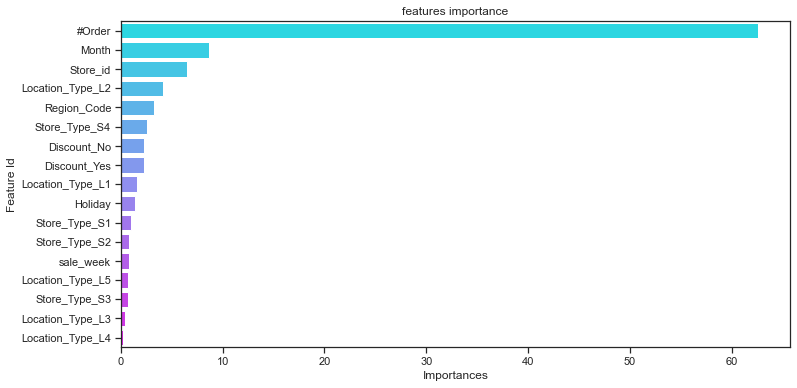

In [52]:
# Create a dataframe of feature importance 
df_feature_importance = pd.DataFrame(cat_model.get_feature_importance(prettified=True))

#plotting feature importance
plt.figure(figsize=(12, 6))

feature_plot= sns.barplot(x="Importances", y="Feature Id", data=df_feature_importance,palette="cool")

plt.title('features importance')